# Example: crack branching

See Section 5.2 Crack Branching in Homalite in [1]

[1] Bobaru, F., & Zhang, G. (2015). Why do cracks branch? A peridynamic 
investigation of dynamic brittle fracture. International Journal of Fracture,
196, 59-98.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import google.colab

    IN_COLAB = True
    !pip install git+https://github.com/mark-hobbs/pypd.git
    print("Package installed successfully")
    import pypd
except ImportError:
    IN_COLAB = False
    import pypd

    print("Not running in Colab")

Not running in Colab


In [2]:
if IN_COLAB:
    try:
        gpu_info = !nvidia-smi
        gpu_info = "\n".join(gpu_info)
        print("GPU Information:")
        print(gpu_info)
    except:
        print("GPU information not available")

    try:
        import multiprocessing

        cpu_info = f"Number of CPU cores: {multiprocessing.cpu_count()}"
        print("\nCPU Information:")
        print(cpu_info)
    except:
        print("CPU information not available")
else:
    print("Not running in Colab.")

Not running in Colab.


### Functions required to build the input file

In [3]:
def build_particle_coordinates(dx, n_div_x, n_div_y):
    particle_coordinates = np.zeros([n_div_x * n_div_y, 2])
    counter = 0

    for i_y in range(n_div_y):  # depth
        for i_x in range(n_div_x):  # length
            coord_x = dx * i_x
            coord_y = dx * i_y
            particle_coordinates[counter, 0] = coord_x
            particle_coordinates[counter, 1] = coord_y
            counter += 1

    return particle_coordinates

In [4]:
def build_boundary_conditions(particles, dx):
    bc_flag = np.zeros((len(particles), 2), dtype=np.intc)
    bc_unit_vector = np.zeros((len(particles), 2), dtype=np.intc)

    tol = 1e-6

    for i, particle in enumerate(particles):
        if particle[1] < (0.02 + tol):
            bc_flag[i, 1] = 1
            bc_unit_vector[i, 1] = -1
        if particle[1] > (0.18 - dx - tol):
            bc_flag[i, 1] = 1
            bc_unit_vector[i, 1] = 1

    return bc_flag, bc_unit_vector

In [5]:
dx = 1e-3
n_div_x = np.rint(0.4 / dx).astype(int)
n_div_y = np.rint(0.2 / dx).astype(int)
notch = [np.array([0 - dx, 0.1 - (dx / 2)]), np.array([0.2, 0.1 - (dx / 2)])]

In [6]:
x = build_particle_coordinates(dx, n_div_x, n_div_y)
flag, unit_vector = build_boundary_conditions(x, dx)

### Visualise boundary conditions

- Blue nodes indicate that no boundary conditions are applied. 
- Red nodes represent locations where boundary conditions are enforced. 
- Additionally, the direction of the boundary condition is randomly visualised on 200 nodes, with arrows indicating the applied direction and scale.

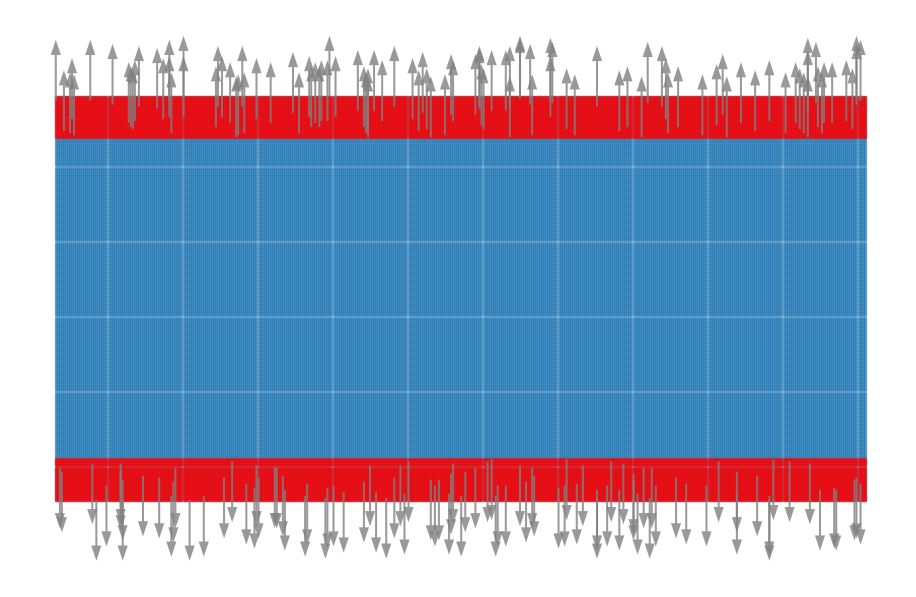

In [7]:
fig, ax = plt.subplots(figsize=(14, 7.5))
ax.scatter(x[:, 0], x[:, 1], marker="o", s=2.5, alpha=0.5)
ax.scatter(
    x[np.where(flag)[0], 0],
    x[np.where(flag)[0], 1],
    marker="o",
    s=2.5,
    c="red",
    alpha=0.5,
)
ax.axis("off")
ax.set_aspect("equal")

arrow_indices = np.random.choice(np.where(flag)[0], size=200, replace=False)
arrow_scale = 0.0225

for idx in arrow_indices:
    ax.arrow(
        x[idx, 0], x[idx, 1],
        arrow_scale * unit_vector[idx, 0],
        arrow_scale * unit_vector[idx, 1],
        head_width=0.005, head_length=0.0075,
        fc='gray', ec='none', alpha=0.8)

ax.axis("off")
ax.set_aspect("equal")

### Build the model

In [8]:
material = pypd.Material(name="homalite", E=4.55e9, Gf=38.46, density=1230, ft=2.5)
bc = pypd.BoundaryConditions(flag, unit_vector, magnitude=1e-4)
particles = pypd.Particles(x, dx, bc, material)
bonds = pypd.Bonds(particles, influence=pypd.Constant, notch=notch)
model = pypd.Model(particles, bonds)

/Users/markhobbs/.local/share/virtualenvs/pypd-EEdp8jsB/lib/python3.11/site-packages/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/.local/share/virtualenvs/pypd-EEdp8jsB/lib/python3.11/site-packages/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator


### Run the simulation and visualise the final state

Is CUDA available: False


Simulation progress: 100%|███████████████████████████████████████████████████████████| 5000/5000 [00:26<00:00, 188.75steps/s]


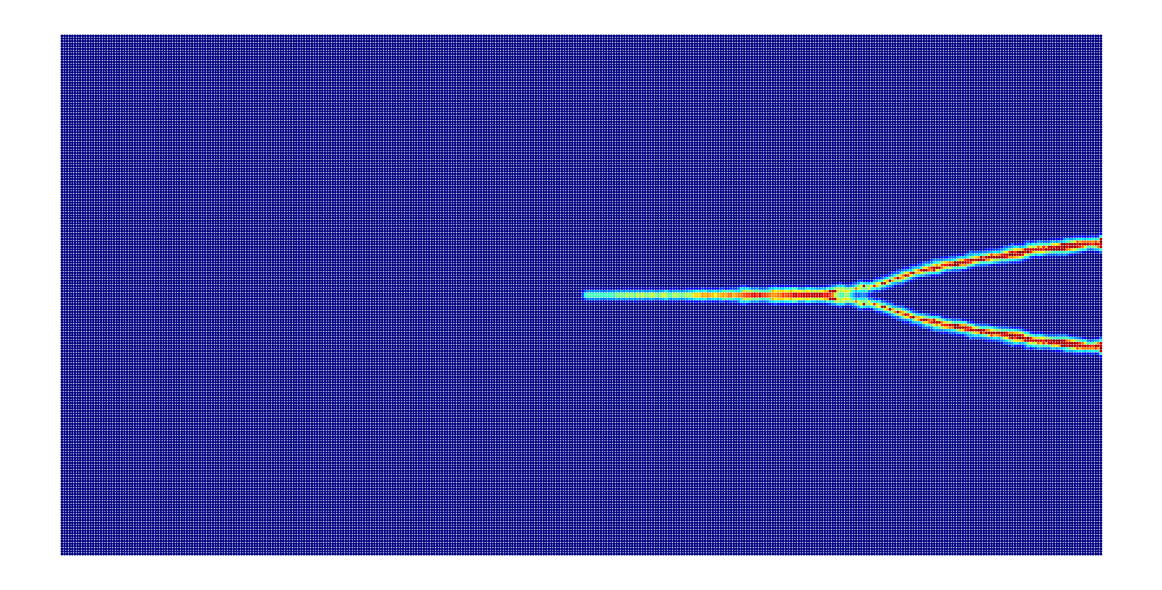

In [9]:
simulation = pypd.Simulation(n_time_steps=5000, damping=0)
simulation.run(model)
model.save_final_state_fig(fig_title="crack-branching", show_axis=False)